In [3]:
image_folder_url = '/content/drive/MyDrive/input/painting'

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
import os
import sys
import random
import warnings

import numpy as np
import pandas as pd
import cv2

import matplotlib.pyplot as plt

from tqdm import tqdm
from itertools import chain
import skimage
from PIL import Image
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.util import crop
from skimage.morphology import label
from skimage.color import rgb2gray, gray2rgb, rgb2lab, lab2rgb
from sklearn.model_selection import train_test_split

from keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input
from keras.models import Model, load_model,Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Dense, UpSampling2D, RepeatVector, Reshape
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras import backend as K
import datetime
# import tensorflow.compat.v1 as tf
# tf.compat.v1.disable_eager_execution()


warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 42
random.seed = seed
np.random.seed = seed

In [6]:
IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_CHANNELS = 3
INPUT_SHAPE=(IMG_HEIGHT, IMG_WIDTH, 1)
TRAIN_PATH = image_folder_url

train_ids = next(os.walk(TRAIN_PATH))[2]
print(train_ids)

['1216.jpg', '1226.jpg', '1217.jpg', '1227.jpg', '1214.jpg', '1194.jpg', '1193.jpg', '1219.jpg', '1198.jpg', '1220.jpg', '1197.jpg', '1201.jpg', '1206.jpg', '1212.jpg', '1199.jpg', '1221.jpg', '1196.jpg', '1195.jpg', '1202.jpg', '1204.jpg', '1205.jpg', '1218.jpg', '1237.jpg', '1244.jpg', '1242.jpg', '1252.jpg', '1249.jpg', '1254.jpg', '1234.jpg', '1257.jpg', '1233.jpg', '1240.jpg', '1231.jpg', '1228.jpg', '1247.jpg', '1255.jpg', '1258.jpg', '1246.jpg', '1245.jpg', '1253.jpg', '1235.jpg', '1243.jpg', '1248.jpg', '1229.jpg', '1259.jpg', '1232.jpg', '1241.jpg', '1239.jpg', '1256.jpg', '1230.jpg', '1251.jpg', '1238.jpg', '1274.jpg', '1291.jpg', '1265.jpg', '1270.jpg', '1278.jpg', '1281.jpg', '1285.jpg', '1283.jpg', '1272.jpg', '1289.jpg', '1290.jpg', '1295.jpg', '1284.jpg', '1288.jpg', '1277.jpg', '1286.jpg', '1287.jpg', '1294.jpg', '1293.jpg', '1261.jpg', '1267.jpg', '1296.jpg', '1297.jpg', '1263.jpg', '1280.jpg', '1262.jpg', '1266.jpg', '1269.jpg', '1273.jpg', '1271.jpg', '1279.jpg', '12

In [7]:
%%time
X_train = np.zeros((len(train_ids)-86, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
missing_count = 0
print('Getting train images ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    path = TRAIN_PATH + '/' + id_+''
    try:
        img = imread(path)
        img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
        X_train[n-missing_count] = img
    except:
#         print(" Problem with: "+path)
        missing_count += 1

X_train = X_train.astype('float32') / 255.
print("Total missing: "+ str(missing_count))

Getting train images ... 


100%|██████████| 2033/2033 [01:15<00:00, 27.07it/s]


Total missing: 86
CPU times: user 49 s, sys: 1.46 s, total: 50.5 s
Wall time: 1min 15s


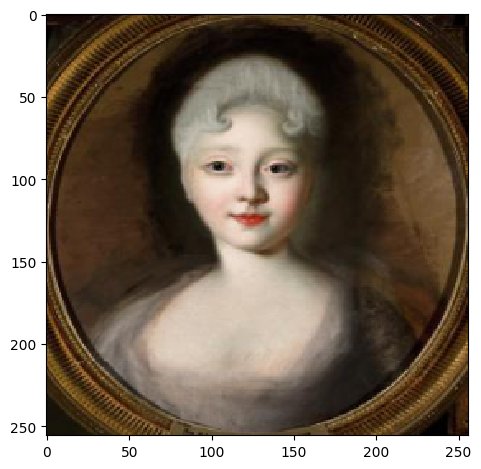

In [8]:
imshow(X_train[5])
plt.show()

In [9]:
X_train, X_test = train_test_split(X_train, test_size=20, random_state=seed)

In [10]:
inception = InceptionResNetV2(weights=None, include_top=True)
inception.load_weights('/content/drive/MyDrive/input/inception-resnet-v2-weights/inception_resnet_v2_weights_tf_dim_ordering_tf_kernels.h5')
# inception.graph = tf.compat.v1.get_default_graph()

In [11]:
def Colorize():
    embed_input = Input(shape=(1000,))
    
    #Encoder
    encoder_input = Input(shape=(256, 256, 1,))
    encoder_output = Conv2D(128, (3,3), activation='relu', padding='same',strides=1)(encoder_input)
    encoder_output = MaxPooling2D((2, 2), padding='same')(encoder_output)
    encoder_output = Conv2D(128, (4,4), activation='relu', padding='same')(encoder_output)
    encoder_output = Conv2D(128, (3,3), activation='relu', padding='same',strides=1)(encoder_output)
    encoder_output = MaxPooling2D((2, 2), padding='same')(encoder_output)
    encoder_output = Conv2D(256, (4,4), activation='relu', padding='same')(encoder_output)
    encoder_output = Conv2D(256, (3,3), activation='relu', padding='same',strides=1)(encoder_output)
    encoder_output = MaxPooling2D((2, 2), padding='same')(encoder_output)
    encoder_output = Conv2D(256, (4,4), activation='relu', padding='same')(encoder_output)
    encoder_output = Conv2D(256, (3,3), activation='relu', padding='same')(encoder_output)
    encoder_output = Conv2D(256, (3,3), activation='relu', padding='same')(encoder_output)
    
    #Fusion
    fusion_output = RepeatVector(32 * 32)(embed_input) 
    fusion_output = Reshape(([32, 32, 1000]))(fusion_output)
    fusion_output = concatenate([encoder_output, fusion_output], axis=3) 
    fusion_output = Conv2D(256, (1, 1), activation='relu', padding='same')(fusion_output)
    
    #Decoder
    decoder_output = Conv2D(128, (3,3), activation='relu', padding='same')(fusion_output)
    decoder_output = Conv2D(64, (3,3), activation='relu', padding='same')(decoder_output)
    decoder_output = UpSampling2D((2, 2))(decoder_output)
    decoder_output = Conv2D(128, (3,3), activation='relu', padding='same')(decoder_output)
    decoder_output = UpSampling2D((2, 2))(decoder_output)
    decoder_output = Conv2D(64, (4,4), activation='relu', padding='same')(decoder_output)
    decoder_output = Conv2D(64, (3,3), activation='relu', padding='same')(decoder_output)
    decoder_output = Conv2D(32, (2,2), activation='relu', padding='same')(decoder_output)
    decoder_output = Conv2D(2, (3, 3), activation='tanh', padding='same')(decoder_output)
    decoder_output = UpSampling2D((2, 2))(decoder_output)
    return Model(inputs=[encoder_input, embed_input], outputs=decoder_output)

model = Colorize()
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_203 (Conv2D)            (None, 256, 256, 12  1280        ['input_3[0][0]']                
                                8)                                                                
                                                                                                  
 max_pooling2d_4 (MaxPooling2D)  (None, 128, 128, 12  0          ['conv2d_203[0][0]']             
                                8)                                                            

In [12]:
%%time

# Image transformer
datagen = ImageDataGenerator(
        shear_range=0.2,
        zoom_range=0.2,
        rotation_range=20,
        horizontal_flip=True)

#Create embedding
def create_inception_embedding(grayscaled_rgb):
    def resize_gray(x):
        return resize(x, (299, 299, 3), mode='constant')
    grayscaled_rgb_resized = np.array([resize_gray(x) for x in grayscaled_rgb])
    grayscaled_rgb_resized = preprocess_input(grayscaled_rgb_resized)
    embed = inception.predict(grayscaled_rgb_resized)
    return embed

#Generate training data
def image_a_b_gen(dataset=X_train, batch_size = 20):
    for batch in datagen.flow(dataset, batch_size=batch_size):
        X_batch = rgb2gray(batch)
        grayscaled_rgb = gray2rgb(X_batch)
        lab_batch = rgb2lab(batch)
        X_batch = lab_batch[:,:,:,0]
        X_batch = X_batch.reshape(X_batch.shape+(1,))
        Y_batch = lab_batch[:,:,:,1:] / 128
        yield [X_batch, create_inception_embedding(grayscaled_rgb)], Y_batch
        

CPU times: user 63 µs, sys: 0 ns, total: 63 µs
Wall time: 68.7 µs


In [13]:
# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='loss', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5,
                                            min_lr=0.00001)
filepath = "content/Art_Colorization_Model.h5"
checkpoint = ModelCheckpoint(filepath,
                             save_best_only=True,
                             monitor='loss',
                             mode='min')

model_callbacks = [learning_rate_reduction,checkpoint]

In [17]:
%%time
BATCH_SIZE = 20
history = model.fit(image_a_b_gen(X_train,BATCH_SIZE),
            epochs=30,
            verbose=1,
            steps_per_epoch=X_train.shape[0]/BATCH_SIZE,
             callbacks=model_callbacks)

1/1 [==============================] - 0s 88ms/step
Epoch 1/30
96/96 [==============================] - 145s 2s/step - loss: 0.0095 - lr: 0.0010
Epoch 2/30
96/96 [==============================] - 137s 1s/step - loss: 0.0052 - lr: 0.0010
Epoch 3/30
96/96 [==============================] - 137s 1s/step - loss: 0.0050 - lr: 0.0010
Epoch 4/30
96/96 [==============================] - 137s 1s/step - loss: 0.0048 - lr: 0.0010
Epoch 5/30
96/96 [==============================] - 140s 1s/step - loss: 0.0047 - lr: 0.0010
Epoch 6/30
96/96 [==============================] - 138s 1s/step - loss: 0.0047 - lr: 0.0010
Epoch 7/30
96/96 [==============================] - 139s 1s/step - loss: 0.0046 - lr: 0.0010
Epoch 8/30
96/96 [==============================] - 138s 1s/step - loss: 0.0045 - lr: 0.0010
Epoch 9/30
96/96 [==============================] - 139s 1s/step - loss: 0.0044 - lr: 0.0010
Epoch 10/30
96/96 [==============================] - 139s 1s/step - loss: 0.0044 - lr: 0.0010
Epoch 11/30
96/96

In [18]:
model.save(filepath)
model.save_weights("Art_Colorization_Weights.h5")


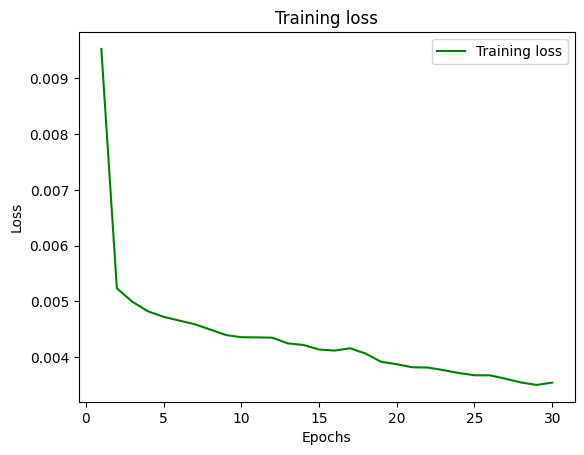

In [19]:
loss_train = history.history['loss']
#loss_val = history.history['val_loss']
epochs = range(1,31)
plt.plot(epochs, loss_train, 'g', label='Training loss')
#plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [20]:
sample = X_test
color_me = gray2rgb(rgb2gray(sample))
color_me_embed = create_inception_embedding(color_me)
color_me = rgb2lab(color_me)[:,:,:,0]
color_me = color_me.reshape(color_me.shape+(1,))

output = model.predict([color_me, color_me_embed])
output = output * 128

decoded_imgs = np.zeros((len(output),256, 256, 3))

for i in range(len(output)):
    cur = np.zeros((256, 256, 3))
    cur[:,:,0] = color_me[i][:,:,0]
    cur[:,:,1:] = output[i]
    decoded_imgs[i] = lab2rgb(cur)
    cv2.imwrite("img_"+str(i)+".jpg", lab2rgb(cur))

1/1 [==============================] - 0s 380ms/step


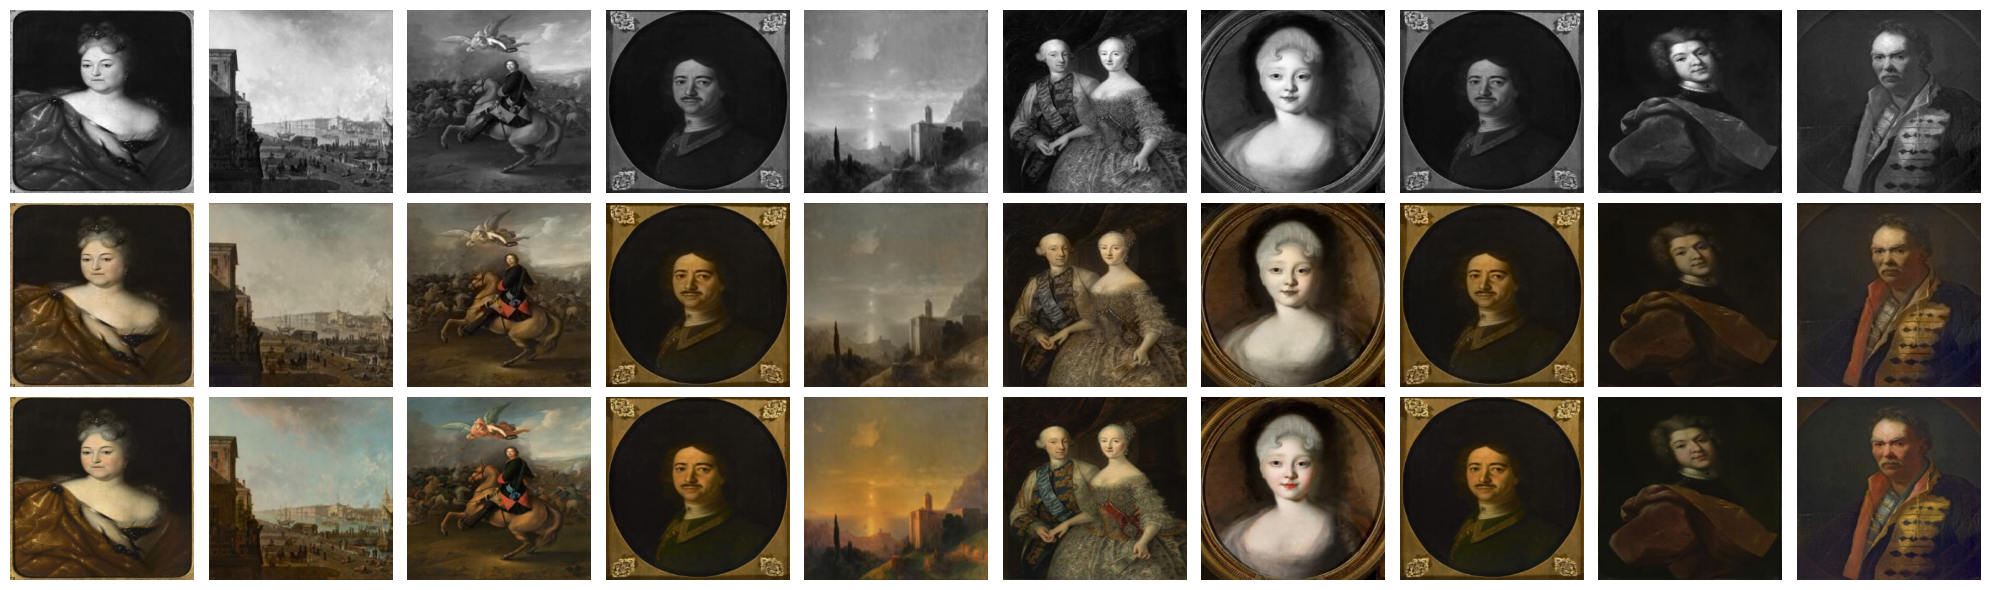

In [21]:
plt.figure(figsize=(20, 6))
for i in range(10):
    # grayscale
    plt.subplot(3, 10, i + 1)
    plt.imshow(rgb2gray(X_test)[i].reshape(256, 256))
    plt.gray()
    plt.axis('off')
 
    # recolorization
    plt.subplot(3, 10, i + 1 +10)
    plt.imshow(decoded_imgs[i].reshape(256, 256,3))
    plt.axis('off')
    
    # original
    plt.subplot(3, 10, i + 1 + 20)
    plt.imshow(X_test[i].reshape(256, 256,3))
    plt.axis('off')
 
plt.tight_layout()
plt.show()